In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import convolve
import matplotlib.animation as animation
import warnings
import json
import scipy
import os

import discrete_CRISPR_methods as ds
import discrete_CRISPR_sim_methods as ds2

In [2]:
params = { #parameters relevant for the equations
    "Nh":              10,
    "N0":               1,
    "R0":              10,
    "M":               10, #Also L, total number of spacers
    "D":                3, #Unused
    "mu":             0.1, #mutation rate
    "gamma_shape":     20, 
    "Np":              10, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":              0.5, #cross-reactivity kernel
    "rho":           5e-5, #spacer sharing coeff
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    5,
    "dx":                         1,
    "t0":                         0, 
    "tf":                       100,
    "dt":                         1,
    "noise_mean":                 0,
    "noise_std":                0.1,
    "initial_mean":           [0,0],
    "initial_var":                5,
    "n_step_prior":               5,
    "folder_name":  "simulation#11/",
    "conv_size":                  1,
}

In [7]:
x_range = sim_params["xdomain"] #Initialize the spaces
dx = sim_params["dx"]
x_linspace = np.arange(-x_range, x_range, dx)
x_size = np.size(x_linspace)
sim_params["x_size"] = x_size

t_size = (sim_params["tf"]-sim_params["t0"])/sim_params["dt"]

s = np.zeros([x_size, x_size], dtype=int)
n = np.zeros([x_size, x_size], dtype=int) 
nh = np.zeros([x_size, x_size], dtype=int) #nh(x,t) = Nh*h(x,t) there should be a total of Nh*M elements 
coordmap = np.meshgrid(x_linspace, x_linspace) #coordmap is kinda stupid since we are not in any real space
c = nh.copy() # c is unused (supposed to be coverage)

In [8]:
n = ds2.init_n(n, params, sim_params)
nh = ds2.init_nh(nh, params, sim_params)


In [9]:
t_start = sim_params["t0"] #Time parameters
t_stop = sim_params["tf"]
t_step = sim_params["dt"]

frames_n = [] #Store the frames as gifs
frames_nh = []
frames_f = []
times = []

N = []

for t in np.arange(t_start, t_stop, t_step):

    f = ds.fitness_shared_spacers(n, nh, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    n = ds.virus_growth(n, f, params, sim_params) #update
    n = ds.mutation(n, params, sim_params)

    nh = ds.immunity_gain(nh, n) #update nh
    nh = ds.immunity_loss(nh, n)

    current_N = np.sum(n)
    current_Nh = np.sum(nh)
    
    frames_nh.append([nh])
    frames_f.append([f])
    frames_n.append([n])
    times.append([t])
    N.append([current_N])

    n_step_prior = sim_params["n_step_prior"]

    # if (current_N > current_Nh/2) and (t > (t_stop - t_start)/2):
    #     print("Population Reset")
    #     break

    if (current_N == 0):
        print("Population Death")
        break

In [ ]:
num = 0
sim_params["folder_name"] = "Simulation#" + str(num)

In [94]:
def fitness_spacers(n, nh, params, sim_params):
    R0 = params["R0"]
    M = params["M"]
    Nh = params["Nh"]
    Np = params["Np"]

    h = nh/Nh
    P0 = ds.p_single_spacer(h, params, sim_params)
    P_0_spacer = ds.binomial_pdf(M, 0, P0)

    P_1_spacer = ds.binomial_pdf(M, 1, P0)
    P_shared = 0
    for d in range(1, Np):
        P_shared += ds.binomial_pdf(Np, d, 1/M)*P_1_spacer*(-1*ds.alpha(d, params))

    P_tt = P_shared +P_0_spacer

    if (np.min(P_0_spacer-P_shared)) < 0:
        raise ValueError

    eff_R0 = P_tt*R0
    mask = (eff_R0 <= 0)
    ma_eff_R0 = ma.masked_array(eff_R0, mask = mask)
    res = ma.log(ma_eff_R0)

    mask2 = ((1+res*sim_params["dt"])<=0).filled()
    res.mask = mask2
    return res

In [84]:
np.min(P_0_spacer-P_shared)

0.0011789351943558152

In [79]:
R0 = params["R0"]
M = params["M"]
Nh = params["Nh"]
Np = params["Np"]

h = nh/Nh
P0 = ds.p_single_spacer(h, params, sim_params)
P_0_spacer = ds.binomial_pdf(M, 0, P0)

P_1_spacer = ds.binomial_pdf(M, 1, P0)
P_tt = 0
for d in range(1, Np):
    P_tt += ds.binomial_pdf(Np, d, 1/M)*P_1_spacer*(-1*ds.alpha(d, params))

P_shared = P_tt
P_tt = P_0_spacer + P_tt

In [51]:
np.max(P_0_spacer)

1.0

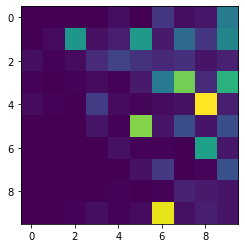

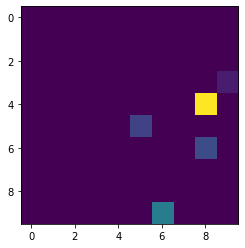

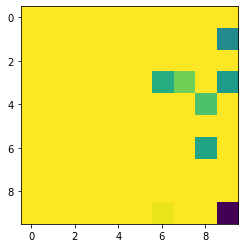

In [76]:
sim_params["folder_name"] = "Test"

os.mkdir(sim_params["folder_name"])
os.chdir(sim_params["folder_name"])

ds.write2json("", params, sim_params)
ds.makeGif(frames_n, "n_simulation")
ds.makeGif(frames_nh, "nh_simulation")
ds.makeGif(frames_f, "f_simulation")

os.chdir("../")

In [7]:
def update(n, nh):

    f = ds.fitness(nh, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
    n = ds.virus_growth(n, f, params, sim_params) #update n
    n = ds.mutation(n, params, sim_params)

    nh = ds.immunity_gain(nh, n) #update nh
    nh = ds.immunity_loss(nh, n)

    return n, nh

In [85]:
def binomial_pdf(n, x, p):
    multiplicity = scipy.special.binom(n, x)
    bernouilli = (p**x)*((1-p)**(n-x))
    return multiplicity*bernouilli

def p_single_spacer(h, params, sim_params):
    return h/params["M"]

In [103]:
M = params["M"]
Np = params["Np"]
h = nh/Nh
P0 = p_single_spacer(h, params, sim_params)
P_0_spacer = binomial_pdf(M, 0, P0)

P_1_spacer = binomial_pdf(M, 1, P0)
P_tt = P_0_spacer
for d in range(1, Np):
    P_tt += binomial_pdf(Np, d, 1/M)*P_1_spacer*(1-ds.alpha(d, params))